# Exploring DeSilva Electrical Conductivity Data

**Jack Haas**

This notebook is the first I am using to explore the DeSilva dataset. This is the first step for the Honors Option for MSU's CMSE 492 instructed by Dr. Murillo. The data and recreated visuals are sourced from [this repository](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database).

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hiplot as hip

## EDA

### Recreating and Adapting

[Original source](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database/blob/master/database/DeSilvaKatsouros/View_DeSilva_data.ipynb)

In [22]:
combined_df = pd.read_csv('combined_cond.csv') # Read combined data

In [23]:
hip.Experiment.from_csv("combined_cond.csv").display()

<IPython.core.display.Javascript object>

In [24]:
combined_df.head()

,T(K),log10(rho),log10(con),Z,Znuc
0,6000,0.093828,5.66955,1.723060,13
1,10000,-0.130498,5.09673,1.384340,13
2,10000,-0.302135,4.66938,1.163650,13
3,8000,-0.565000,4.02305,0.881093,13
4,6000,-0.764547,3.35545,0.703443,13


**Feature Description:**


| Feature      | Description | Units |
| ----------- | ----------- | ----------- |
| T(K)      | Temperature   | K |
| log10(rho)  | Density       | g/cc |
| log10(con)    | Conductivity  | S/m |
| Z     | ?       |  ? |
| Znuc     | Atomic #       | None |


In [25]:
combined_df.describe()

,T(K),log10(rho),log10(con),Z,Znuc
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,14498.472816,-0.548563,4.531197,1.709120,34.905925
std,7557.814904,0.953941,0.766991,0.850058,21.603132
min,4000.000000,-2.634510,2.466870,0.586096,13.000000
25%,10000.000000,-1.322030,3.978870,1.130270,26.000000
50%,14000.000000,-0.447697,4.289210,1.426290,28.000000
75%,18000.000000,0.242104,5.175070,2.002520,29.000000
max,42000.000000,1.116750,6.309500,4.733120,74.000000


In [26]:
to_name = {13:'Al', 26:'Ni', 28:'Fe', 29:'Cu', 74:'W'} # dictionary of atomic number to element name

def viz_element(element):
    plt.figure(figsize=(10,6))
    one_element = combined_df[combined_df["Znuc"]==element]
    plt.scatter(one_element["T(K)"], one_element["log10(con)"], c=one_element["log10(rho)"], label = element)
    plt.xlabel("T [K]")
    plt.ylabel("$\log_{10}(\sigma)$")
    plt.grid(alpha = 0.3)
    plt.text(22000, 3.3, f"Atomic #: {element}", fontsize=40, backgroundcolor = 'w', size=18)
    plt.title(to_name[element], size=18)
    plt.colorbar(label="log$_{10}$(ρ)")

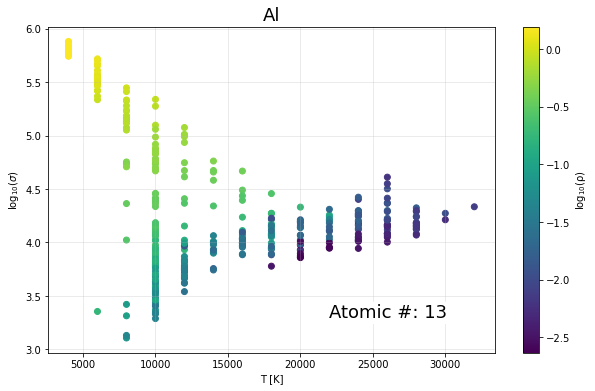

In [27]:
viz_element(13) # Al

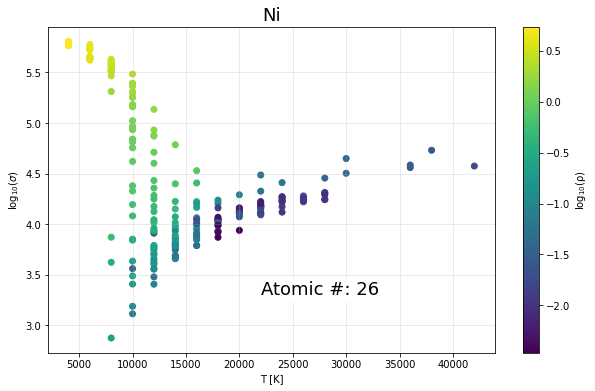

In [28]:
viz_element(26) # Ni

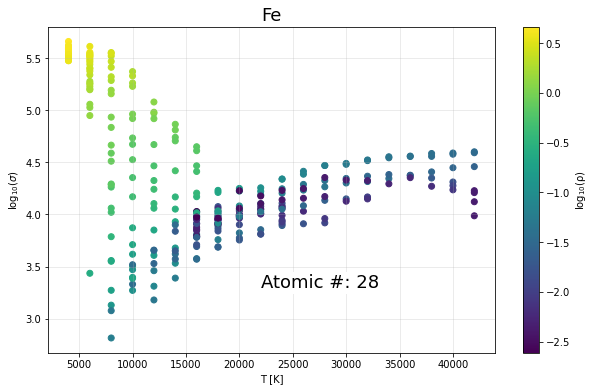

In [29]:
viz_element(28) # Fe

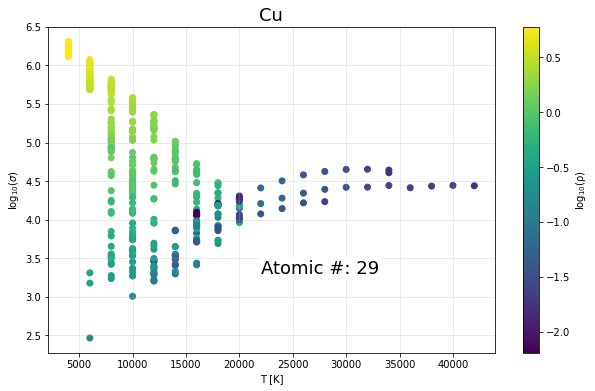

In [30]:
viz_element(29) # Cu

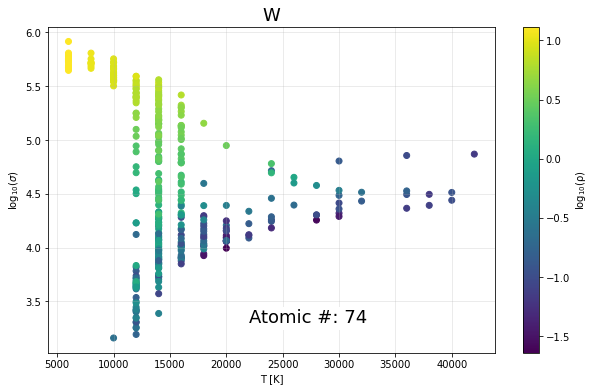

In [31]:
viz_element(74) # W

### Bonus

In [32]:
import seaborn as sns

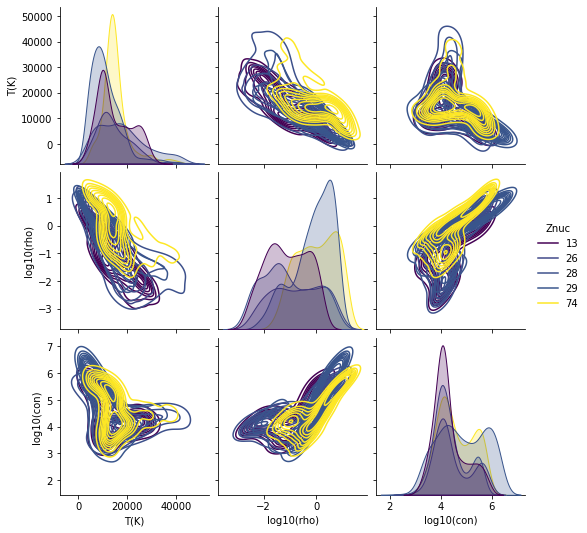

In [33]:
sns.pairplot(combined_df[['T(K)', 'log10(rho)','log10(con)', 'Znuc']], hue="Znuc", kind="kde", palette='viridis')

In [34]:
combined_df['Znuc'].value_counts()

29    420
74    360
13    349
28    288
26    220
Name: Znuc, dtype: int64

## Classification of Elements

In [35]:
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# classifiecation models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [36]:
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(['Znuc'], axis=1), combined_df['Znuc'], test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [37]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# ML Survey
try:
    model_survey = pd.read_csv('clf_model_survey_data.csv')
except:
    model_survey = pd.DataFrame(columns=['model', 'accuracy'])
    for name, clf in zip(names, classifiers):
        clf.fit(X_train_s, y_train)
        score = clf.score(X_test_s, y_test)
        model_survey = pd.concat([model_survey, pd.DataFrame({'model':name, 'accuracy':score}, index=[0])], ignore_index=True)
    model_survey.to_csv('clf_model_survey_data.csv')

model_survey

,model,accuracy
0,Nearest Neighbors,0.777439
1,Linear SVM,0.326220
2,RBF SVM,0.695122
3,Gaussian Process,0.222561
4,Decision Tree,0.600610
5,Random Forest,0.618902
6,Neural Net,0.658537
7,AdaBoost,0.414634
8,Naive Bayes,0.445122
9,QDA,0.634146


## Predicting Conductivity

---